
# LIBRERIAS A **IMPORTAR**


In [ ]:
#!nvidia-smi
from google.colab import drive
drive.mount('/gdrive')



Mounted at /gdrive


In [ ]:

%cd /gdrive/MyDrive/jpg/
!pwd
!ls






/gdrive/MyDrive/jpg
/gdrive/MyDrive/jpg
 dcgan.gif	   image_02049.jpg   image_04098.jpg	    image_06141.jpg
 image_00001.jpg   image_02050.jpg   image_04099.jpg	    image_06142.jpg
 image_00002.jpg   image_02051.jpg   image_04100.jpg	    image_06143.jpg
 image_00003.jpg   image_02052.jpg   image_04101.jpg	    image_06144.jpg
 image_00004.jpg   image_02053.jpg   image_04102.jpg	    image_06145.jpg
 image_00005.jpg   image_02054.jpg   image_04103.jpg	    image_06146.jpg
 image_00006.jpg   image_02055.jpg   image_04104.jpg	    image_06147.jpg
 image_00007.jpg   image_02056.jpg   image_04105.jpg	    image_06148.jpg
 image_00008.jpg   image_02057.jpg   image_04106.jpg	    image_06149.jpg
 image_00009.jpg   image_02058.jpg   image_04107.jpg	    image_06150.jpg
 image_00010.jpg   image_02059.jpg   image_04108.jpg	    image_06151.jpg
 image_00011.jpg   image_02060.jpg   image_04109.jpg	    image_06152.jpg
 image_00012.jpg   image_02061.jpg   image_04110.jpg	    image_06153.jpg
 image_00013.jpg

In [ ]:
#from skimage import io
from google.colab import files #para importar las imagenes

import os #para poder hacer el ls

from google.colab.patches import cv2 #para ver si un archivo es realmente una imagen


import numpy as np#para varias cosas, relacionadas con generar vectores de numeros que sean 1, 0, o ruido


import matplotlib.pyplot as plt #para poder hacer plot de los vectores como imagenes


import tensorflow as tf
from tensorflow import keras# para poder hacer la red de neuronas


import imageio
import glob
#las dos de arriba para hacer los gif

from PIL import Image #para hacer gif mas grandes


# IMPORTAMOS LAS FOTOS







# Procesamos las fotos para meterlas en un array

In [ ]:
from skimage import color
from skimage import io
i=0
#input= "/content" #donde se han cargado las imagenes
input="/gdrive/MyDrive/jpg"
files_names = os.listdir(input) #sacamos todos los elementos de la carpeta actual (hacemos un ls)
coches=[] #creamos una lista vacia#

for f in files_names:
    
    imagepath = input + "/" + f #
    #image = cv2.imread(imagepath)#leemos la foto
    #if image is not  None: #comprobamos que es una imagen
      #coche= color.rgb2gray(io.imread(f))#importante dividir entre 255 #la cargamos en blanco y negro
      #coche=np.resize(coche,(44,44))# le cambiamos el formato a 44x44 pixeles
      #en este caso no hace falta porque vamos a 
      #nuevos coches
    i=i+1
    if (i%100)==0:
        print(i)
    #im = Image.open(imagepath).convert('L')PARA BLANCO Y NEGRO
    im = Image.open(imagepath)#.convert('L')
    #Z=(cv2.resize(np.float32(im), (104, 104))-127.5)/127.5
    Z=cv2.resize(np.float32(im), (56, 56))/255
    #((trainX-127.5)/127.5)
    coches.append(Z) #lo guardo en la lista de coches
   

100
200
300
400
500
600
700
800
900
1000


UnidentifiedImageError: ignored

# Funcion de manrique para la visualizacion de imagenes

In [ ]:
# The plotting function for images of dimension 7x7
dim=56
def view_samples(samples, m, n):
    fig, axes = plt.subplots(figsize=(10, 10), nrows=m, ncols=n, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        #im = ax.imshow(1-img.reshape((dim,dim)), cmap='Greys_r')  #original
        #im = ax.imshow(img.reshape((dim,dim)), cmap='Greys_r')  
        im = ax.imshow(img.reshape((dim,dim,3)))  
    return fig, axes

# Datos necesarios para la GAN

In [ ]:
batch_size=32#TODO ir probando a cambiar el batch size.# en realidad el batch size seria el doble, porque hay batchsize correctas y batchsize incorrectas, asi que el numero de imagenes con el que vamos a entrenar a la red cada vez es el doble
#real = np.ones((batch_size/2, 1))#numero de imagenes correctas que  tendra cada batch 
#fake = np.zeros((batch_size/2, 1))#numero de imagenes incorrectas que  tendra cada batch 
img_width=56
img_height=56
img_channels=3 #1= blanco y negro,3 = rgb
lr=0.1 #Learning rate
#view_samples(coches, 2,5) # para visualizar las imagenes
epochs=16000 # epochs para entrenar la GAN
show_interval=200 #cada cuanto se visualizan las imagenes cuando estemos entrenando la GAN  
tam_dataset=8195
neural_input=400

# Creamos el generador de imagenes

Estructura:100->11X11X128=(15488)->128imagenes() 11x11-> normalizarlo-> 64 imagenes 22x22-> normalizamos -> 44X44 con depth de 1, blanco y negro, supongo que para imagenes en color sera 3

# ESTRUCTURA:
# 400->25088->14x14(128)->28x28(84)->56x56(3)

In [ ]:
 #input 
generator= keras.models.Sequential([
  keras.layers.Dense(14*14*128, input_shape=[neural_input]),#reescalamos de 100 a 11*11*128=15488

  keras.layers.Reshape([14,14,128]),#hacemos imagenes 11*11 con una depth de 128
  keras.layers.BatchNormalization(),#lo normalizamos
  keras.layers.Conv2DTranspose(84,kernel_size=5,strides=2,padding="same",activation="selu"),#red convolucional transpuesta-> depth de 64,cada dimension la multiplica *2(stride=2) -> 22X22, pero solo con depth 64, aplicamos filtros 5*5
  keras.layers.BatchNormalization(),#lo normalizamos
  keras.layers.Conv2DTranspose(3,kernel_size=5,strides=2,padding="same",activation='tanh'),#44*44(1)



],name="Generador")


El unico problema es que crea las imagenes, y cada pixel en vez de ir de 0 a 1, en este caso va de -1 a 1, asi que hay dos opciones, canviar la salida del generador para que vaya de 0 a 1, o nuestras imagenes cambiarlas para que vayan de -1 a 1, que creo que hare esto. 
PARA ello a cada pixel le multiplico *2 y despues le resto 1.
Cuando ya tenga las imagenes, para visualizarlas seria al reves pero en orden inverso(suposicion mia, IMPORTANTE COMPROBAR). 
Sumarle 1 y despues dividirlo entre 2
dividir entre 2 y despues sumarle 1 MAL MAL MAL

# Creamos el discriminador de imagenes

Estructura->input 44x44(1)->  64 filtros 5x5(en vez de usar maxpooling, hago stride 2 IMPORTANTE COMPROBAR CUAL ES MEJRO)-> 22x22 y hago dropout(consultar por que IMPORTANTE COMPROBAR)-> 128 filtros 5x5 para imagenes 22x22 con strides de 2 asi que se queda 11x11-> dropout de 0.4-> layer plana de 15488 y despues de 1.(IMPORTANTE COMPROBAR meter alguna layer plana intermedia)

# ESTRUCTURA->56x56(3)->28X28(84)->14x14(162)->31752->1





In [ ]:

discriminator= keras.models.Sequential([
  keras.layers.Conv2D(84,kernel_size=5,strides=2,padding="same",activation=keras.layers.LeakyReLU(0.2),input_shape=[56,56,3]),
  keras.layers.Dropout(0.3),
  keras.layers.Conv2D(128,kernel_size=5,strides=2,padding="same",activation=keras.layers.LeakyReLU(0.2)),
  keras.layers.Dropout(0.3),#antes 0.4
  keras.layers.Flatten(),
  #keras.layers.Dense(2003, activation="selu"),
  keras.layers.Dense(203, activation="selu"),
  keras.layers.Dense(1,activation="sigmoid")
  
],name='Discriminador')




In [ ]:
X_train2 = np.expand_dims(coches, axis=4)# le reducimos una dimension y lo dejamo preparado para poder hacer el reshape(multiplicarlo*2 y despues restarle uno)
X_train=X_train2.reshape(8195,56,56,3)


#X_train=trainX
#X_train=  X_train.reshape(-1,28,28,1)*2.-1

ValueError: ignored

In [ ]:
print(discriminator.summary())

Model: "Discriminador"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 28, 28, 84)        6384      
                                                                 
 dropout_16 (Dropout)        (None, 28, 28, 84)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 14, 14, 128)       268928    
                                                                 
 dropout_17 (Dropout)        (None, 14, 14, 128)       0         
                                                                 
 flatten_8 (Flatten)         (None, 25088)             0         
                                                                 
 dense_19 (Dense)            (None, 203)               5093067   
                                                                 
 dense_20 (Dense)            (None, 1)               

# GAN

el generador no hace falta compilarlo porque solo se entrenara gracias a la gan, pero no lo entrenamos a parte como el drscriminador

In [ ]:
GAN = keras.models.Sequential([generator, discriminator],name="DCGAN")
discriminator.compile(loss='binary_crossentropy',optimizer="rmsprop", metrics=['accuracy'])
discriminator.trainable=False
GAN.compile(loss='binary_crossentropy', optimizer="rmsprop", metrics=['accuracy'])


(<Figure size 720x720 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f01200a3b50>,
       dtype=object))

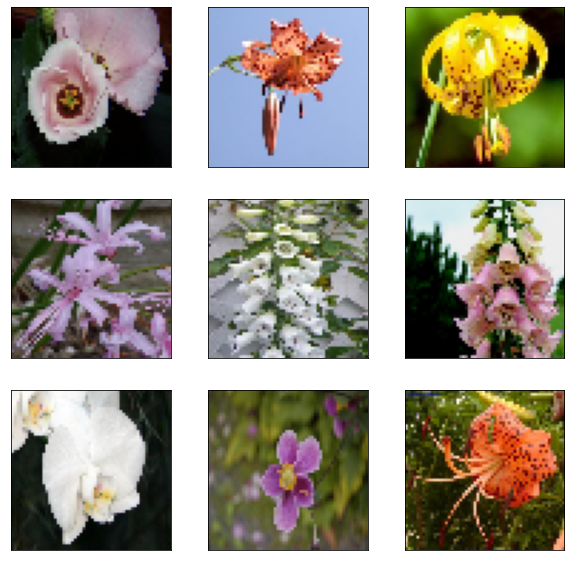

In [ ]:
neural_input=400
noise = np.random.normal(0, 1, (batch_size, neural_input))#entrada de la red neuronal
fake_data = generator.predict(noise)#como se general elementos a traves del generador(al principio sera ruido, pero cuando ya este entrenada la gan asi se generan las imagenes de los coches)
view_samples(coches, 3,3)


In [ ]:
# est ecodigo lo he sacado de aqui 
#https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/
import matplotlib.pyplot as pyplot
def plot_history(d1_hist, d2_hist, a1_hist, a2_hist):
	# plot loss
	pyplot.subplot(2, 1, 1)
	pyplot.plot(d1_hist, label='perdida discriminador')
	#pyplot.plot(a1_hist, label='Precision discriminador')

	pyplot.legend()
 	###### el otro loss

	pyplot.subplot(2, 1, 2)
	pyplot.plot(d2_hist, label='perdida generador')
	#pyplot.plot(a2_hist, label='Gaccuracy')
	pyplot.legend()
 
	# plot discriminator accuracy
	#pyplot.subplot(2, 1, 1)
	#pyplot.plot(a1_hist, label='Daccuracy')
	#pyplot.plot(a2_hist, label='Gaccuracy')
	#pyplot.legend()
	# save plot to file
	pyplot.savefig('./plot_line_plot_loss.png')
	pyplot.close()


In [ ]:

plot_history(dl,gl,da,ga)

In [ ]:
import numpy
print ("media discriminador loss =",numpy.mean(dl))
print ("media generador loss =",numpy.mean(gl))
print ("varianza discriminador loss =",numpy.var(dl))
print ("varianza generador loss =",numpy.var(gl))


print ("media accuracy =",numpy.mean(da))
print ("varianza accuracy  =",numpy.var(da))

media discriminador loss = 0.6481740979797374
media generador loss = 1.7028470444349832
varianza discriminador loss = 0.4454947731888036
varianza generador loss = 12.190777226287409
media accuracy = 0.6625
varianza accuracy  = 0.01409130859375


1
199
399
599
799
999
1199
1399
1599
1799
1999
2199
2399
2599
2799
2999
3199
3399
3599
3799
3999
4199
4399
4599
4799
4999
5199
5399
5599
5799
5999
6199
6399
6599
6799
6999
7199
7399
7599
7799
7999
8199
8399
8599
8799
8999
9199
9399
9599
9799
9999
10199
10399
10599
10799
10999
11199
11399
11599
11799
11999
12199
12399
12599
12799
12999
13199
13399
13599
13799
13999
14199
14399
14599
14799
14999
15199
15399
15599
15799
15999


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

(<Figure size 720x720 with 25 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f00f8e1f5d0>,
       dtype=object))

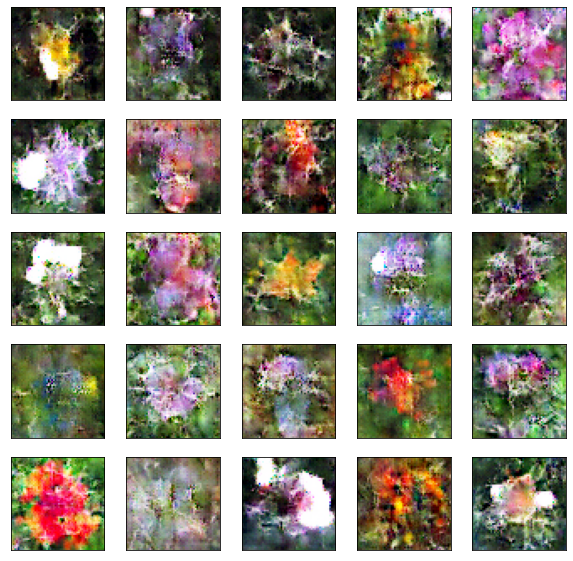

In [ ]:
#este es el que va BIEN
generadas=[]
dl=[]
da=[]
gl=[]
ga=[]
ruidoo=tf.random.normal(shape=[1,neural_input])
generada=generator.predict(ruidoo)
i=0

generator, discriminator= GAN.layers
for epoch in range(epochs):
  
     #reales
     real = X_train[np.random.randint(0, tam_dataset, int(batch_size/2))]#cojo batch/2 veces numeros entre 0 y 8100

     #fake
     fake = generator.predict(tf.random.normal(shape=[int(batch_size/2),neural_input]))

     #fake y real concatenados

     #imagenes
     fakeAndReal = tf.concat([fake,real], axis=0)
     #resultados -> 0 es fake y 1 es real 
     y1= tf.constant([[0.]]*int(batch_size/2)+[[1.]]*int(batch_size/2))

     #entrenamos el discriminador
     discriminator.trainable=True
     #disloss,disacc=discriminator.train_on_batch(fakeAndReal,y1)
     discriminator.train_on_batch(fakeAndReal,y1)
     #dl.append(disloss)
     #da.append(disacc)

     #y ahora el generador
     #explicar mejor abajo, pero aqui le hacemos creer al discriminador que las imagenes son reales y solo cambiamos el 
    #generador para que cambie los pesos y entrene
     #el generador se entrena solo con imagenes falsas, porque tienen que pasar por la entrada de tamaño neural input aue es 400, las reales no se podria hacer eso 
     noise=tf.random.normal(shape=[batch_size,neural_input])
     y2= tf.constant([[1.]]*batch_size)
     discriminator.trainable=False
     #genloss,genacc=GAN.train_on_batch(noise,y2)
     GAN.train_on_batch(noise,y2)

     #gl.append(genloss)
     #ga.append(genacc)


      #cosas necesarias para:
      #ver las imagenes cada ciertas epochs
      #guardar imagenes para poder hacer gifts
     if (epoch==1) | ((epoch+1) % show_interval == 0):
        #print ("%d [Discriminator acc.: %.2f%%] [Generator loss: %f]" % (epoch+1, 100*D_loss[1], G_loss))
        print(epoch)
        #print("perdida discriminador ",disloss, "perdida generador", genloss,"precision discriminador ",disacc)
        #print("precision discriminador ",disacc)#, "acc generador", genacc)
        #noise = np.random.normal(0, 1, (5, neural_input))
        #view_samples(generator.predict(noise), 1,5) 
        generada=generator.predict(ruidoo)
        generadas.append(generada)#cambiar algo[0] por generada 
        output='/content/prueba'+str(i)+'.jpeg'
  
        plt.imsave(output, generada)
        i=i+1
        


noise=tf.random.normal(shape=[batch_size,neural_input])
cosa=generator.predict(noise)
view_samples(cosa, 5,5) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

(<Figure size 720x720 with 80 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f00fbf393d0>,
       dtype=object))

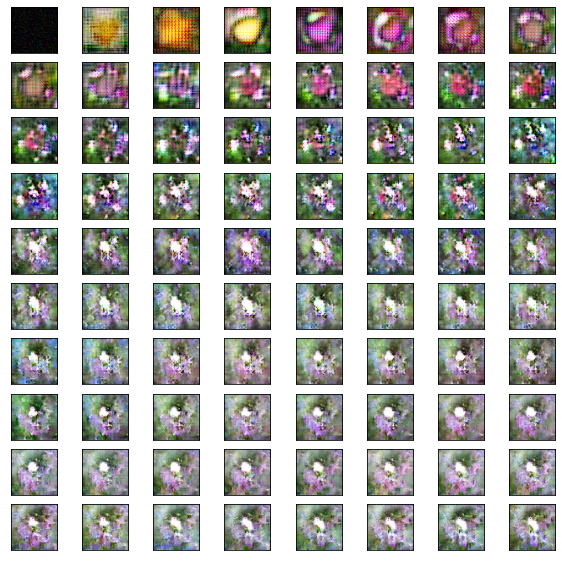

In [ ]:
cosa=generator.predict(noise)
resul=[]
#cosa=(cosa+1)/2
#cosa[1][20]
view_samples(generadas, 10,8) 

# Para crear un gift

In [ ]:
generadas=np.array(generadas)
i=1
for g in generadas:
  g=(g+1)/2
  cosa2=g.reshape(56,56,3)
  output='/content/eee'+str(i)+'.jpeg'
  plt.imsave(output, cosa2)
  i=i*10+1



In [ ]:

filenames = glob.glob('eee*.jpeg')
filenames = sorted(filenames)
i=1
for filename in filenames:
  
    img = cv2.imread(filename, 1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    

    img_scale_up = cv2.resize(img, (0, 0), fx=10, fy=10)


    output='/content/eee'+str(i)+'.jpeg'
    plt.imsave(output, img_scale_up)
    i=i*10+1




In [ ]:

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  
  #filenames = glob.glob('_44*.jpg')
  filenames = glob.glob('eee*.jpeg')
  filenames = sorted(filenames)
  for filename in filenames:
    print("hola")
    print(filename)
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

hola
eee1.jpeg
hola
eee11.jpeg
hola
eee111.jpeg
hola
eee1111.jpeg
hola
eee11111.jpeg
hola
eee111111.jpeg
hola
eee1111111.jpeg
hola
eee11111111.jpeg
hola
eee111111111.jpeg
hola
eee1111111111.jpeg
hola
eee11111111111.jpeg
hola
eee111111111111.jpeg
hola
eee1111111111111.jpeg
hola
eee11111111111111.jpeg
hola
eee111111111111111.jpeg
hola
eee1111111111111111.jpeg
hola
eee11111111111111111.jpeg
hola
eee111111111111111111.jpeg
hola
eee1111111111111111111.jpeg
hola
eee11111111111111111111.jpeg
hola
eee111111111111111111111.jpeg
hola
eee1111111111111111111111.jpeg
hola
eee11111111111111111111111.jpeg
hola
eee111111111111111111111111.jpeg
hola
eee1111111111111111111111111.jpeg
hola
eee11111111111111111111111111.jpeg
hola
eee111111111111111111111111111.jpeg
hola
eee1111111111111111111111111111.jpeg
hola
eee11111111111111111111111111111.jpeg
hola
eee111111111111111111111111111111.jpeg
hola
eee1111111111111111111111111111111.jpeg
hola
eee11111111111111111111111111111111.jpeg
hola
eee1111111111111111

In [ ]:

!pip install git+https://github.com/tensorflow/docs
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-0qotwc83
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-0qotwc83
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=179891 sha256=e34ff4db2bb242df5b2114db80d1315410f8bfd57b9fc7f6fae39ee5e4996cfc
  Stored in directory: /tmp/pip-ephem-wheel-cache-7hbqwf2j/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [ ]:
files.download('./dcgan.gif')
%cd /content/
#!ls

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/content
